In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math, warnings
warnings.filterwarnings("ignore")

PAIR = "EURUSD=X" # yfinance 的外匯代碼
PERIOD = "2y"
FAST, SLOW = 20, 60 # 動能均線
RISK_PER_TRADE = 0.01
STOP_LOSS_PCT = 0.01 # 外匯用更緊的 1% 停損（可改）
INIT_CAPITAL = 100_000

[*********************100%***********************]  1 of 1 completed


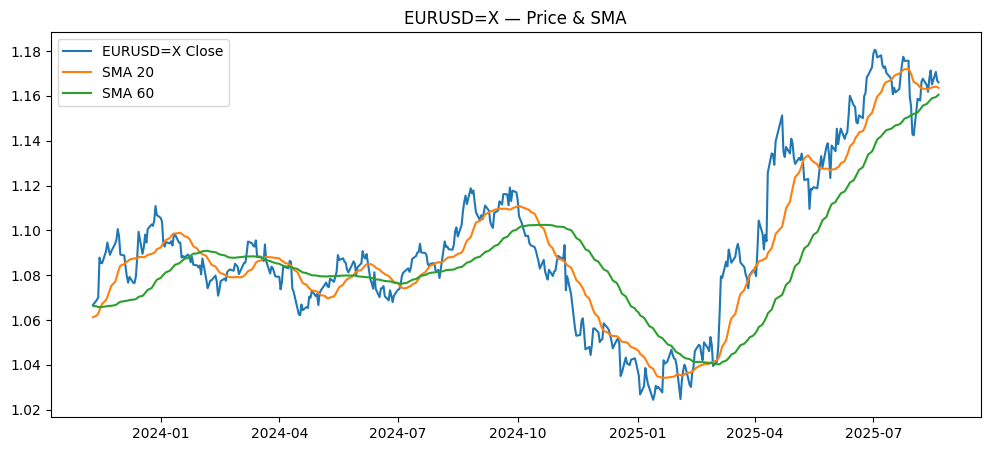

In [6]:
fx = yf.download(PAIR, period=PERIOD, interval="1d", auto_adjust=True).dropna()
fx["SMA_fast"] = fx["Close"].rolling(FAST).mean()
fx["SMA_slow"] = fx["Close"].rolling(SLOW).mean()
fx = fx.dropna()

plt.figure(figsize=(12,5))
plt.plot(fx.index, fx["Close"], label=f"{PAIR} Close")
plt.plot(fx.index, fx["SMA_fast"], label=f"SMA {FAST}")
plt.plot(fx.index, fx["SMA_slow"], label=f"SMA {SLOW}")
plt.legend(); plt.title(f"{PAIR} — Price & SMA"); plt.show()


In [3]:
df = fx.copy()
df["long_entry"] = (df["SMA_fast"].shift(1) <= df["SMA_slow"].shift(1)) & (df["SMA_fast"] > df["SMA_slow"])
df["long_exit"] = (df["SMA_fast"].shift(1) >= df["SMA_slow"].shift(1)) & (df["SMA_fast"] < df["SMA_slow"])

capital = INIT_CAPITAL
position = 0
entry_price = np.nan
equity_curve, trade_log = [], []

for i, row in df.iterrows():
price = row["Close"]

if position > 0:
if (price <= entry_price * (1 - STOP_LOSS_PCT)) or row["long_exit"]:
capital += position * price
trade_log.append(("SELL", i, price))
position = 0
entry_price = np.nan

if position == 0 and row["long_entry"]:
risk_amount = capital * RISK_PER_TRADE
stop_price = price * (1 - STOP_LOSS_PCT)
risk_per_unit = max(price - stop_price, 1e-6)
units = math.floor(risk_amount / risk_per_unit)
cost = units * price
if units > 0 and cost <= capital:
capital -= cost
position = units
entry_price = price
trade_log.append(("BUY", i, price))

equity = capital + position * price
equity_curve.append((i, equity))

eq = pd.DataFrame(equity_curve, columns=["Date","Equity"]).set_index("Date")
ret = eq["Equity"].pct_change().fillna(0)
total_return = eq["Equity"].iloc[-1] / INIT_CAPITAL - 1
max_dd = ((eq["Equity"]/eq["Equity"].cummax())-1).min()

print(f"Final Equity: ${eq['Equity'].iloc[-1]:,.0f}")
print(f"Total Return: {total_return:.2%}")
print(f"Max Drawdown: {max_dd:.2%}")
print(f"Trades: {len(trade_log)}")

fig, ax = plt.subplots(1,2, figsize=(14,4))
ax[0].plot(eq.index, eq["Equity"]); ax[0].set_title("Equity Curve")
ax[1].hist(ret, bins=50); ax[1].set_title("Daily Returns")
plt.show()

pd.DataFrame(trade_log, columns=["Side","Time","Price"]).tail(10)

IndentationError: expected an indented block after 'for' statement on line 10 (2011255783.py, line 11)